> **NOTE** For this Notebook, We recommend that you turn on the GPU in your Colab environment

# Model Training and Evaluation

## Introduction
In this notebook, we will fine-tune a **pre-trained BERT model** for the Named Entity Recognition (NER) task using the CoNLL-2003 dataset. Our model will leverage the knowledge learned from pre-training on large text corpora, while adapting to the specific task of recognizing named entities like **persons (PER)**, **locations (LOC)**, **organizations (ORG)**, and **miscellaneous entities (MISC)**.

## Model Architecture

### Choice of Architecture
We will use a **BERT-based model** (`bert-base-cased`) for this task. BERT (Bidirectional Encoder Representations from Transformers) is a powerful model for NLP tasks due to its ability to capture contextual information bidirectionally (i.e., considering both left and right context). This is particularly important for NER, where the meaning of a token depends on the surrounding words.

### Model Components:
1. **Input Embeddings:** The input sentences will be tokenized and converted into embeddings using the BERT tokenizer. These embeddings represent the semantic meaning of each token.
2. **Transformer Layers:** BERT consists of multiple transformer layers that apply self-attention to capture relationships between tokens in the input sequence.
3. **Dropout Layer:** To prevent overfitting, we will use a **dropout layer** with a probability of 0.1.
4. **Fully Connected (Classification) Layer:** We will add a classification layer on top of BERT to predict the NER tag for each token. This layer will have an output size equal to the number of NER tags (9 in our case).
5. **Softmax Activation:** The final output will use a softmax activation to provide a probability distribution over the NER tags for each token.

### Why This Architecture?
- **Pre-trained Embeddings:** By leveraging pre-trained BERT embeddings, we can start with a model that already understands the general structure and meaning of text.
- **Transformer Layers:** The transformer architecture is well-suited for capturing long-range dependencies, which is essential for recognizing named entities that may span multiple tokens.
- **Classification Layer:** The simple, yet effective, fully connected layer allows us to map the output of BERT to our specific NER tags.

### Layers and Weights
- **Input Layer:** Tokenized input with a maximum length of 128 tokens (padding applied dynamically).
- **BERT Layer:** Pre-trained weights from `bert-base-cased`, fine-tuned on our NER task.
- **Dropout Layer:** Dropout probability set to 0.1 to reduce overfitting.
- **Fully Connected Layer:** Output size of 9 (corresponding to the 9 NER tags), initialized with Xavier initialization for balanced weights.
- **Softmax Layer:** Provides a probability distribution over the tags for each token.

We will also use the **class weights** calculated in the previous notebook to adjust the loss function and handle the class imbalance effectively.


---

## Data DOWNLOAD

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 18.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 18.0.0 which is incompatible.


In [4]:
# Import necessary libraries
from datasets import load_dataset
from transformers import BertTokenizerFast
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import torch

# Load the CoNLL-2003 dataset
dataset = load_dataset("conll2003")

# Initialize the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

# Display the dataset splits
print("Data Downlaoded succesfully")


Data Downlaoded succesfully


In [3]:
import torch

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


---

## Model Implementation

In [5]:
# Import necessary libraries
from transformers import BertForTokenClassification, Trainer, TrainingArguments
import torch

# Load the pre-trained BERT model for token classification
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=9,
    problem_type="single_label_classification"
)

# Load the calculated class weights from the previous notebook
class_weights = torch.tensor([0.1334, 3.4280, 4.9966, 3.5793, 6.1081, 3.1687, 19.5545, 6.5807, 19.5884])
class_weights = class_weights.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Define the loss function with class weights
from torch.nn import CrossEntropyLoss
loss_fn = CrossEntropyLoss(weight=class_weights)

# Move the model to GPU if available (use a gpu pls)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

### **The warning message above is normal**


### What Does This Mean?
This warning indicates that some of the weights in the **`BertForTokenClassification`** model were not loaded from the pre-trained BERT checkpoint (`bert-base-cased`). Specifically, the weights for the **`classifier layer`** (i.e., `classifier.bias` and `classifier.weight`) were **newly initialized** rather than being pre-trained.

### Why Is This Normal and Expected?
This behavior is expected in our case because:

1. **Task-Specific Layers:**
   - The **classifier layer** is a task-specific layer that we added on top of the pre-trained BERT model. In our architecture, we included a fully connected layer (`classifier`) that has an output size of **9**, corresponding to the 9 NER tags (e.g., `O`, `B-PER`, `I-PER`).
   - The pre-trained BERT model (`bert-base-cased`) does not include this classifier layer because it was originally trained on a general language modeling task, not on our specific NER task. Hence, this layer is **newly added** and must be **initialized from scratch**.

2. **Default Weight Initialization:**
   - When a new layer is added (like our classifier), its weights are **randomly initialized** using a default method. This is standard practice in deep learning to ensure that the new layer starts with balanced weights.

3. **Fine-Tuning Step:**
   - The warning message also suggests that we should **train the model on a downstream task**, which is exactly what we are doing. During fine-tuning, the newly initialized weights of the classifier layer will be updated based on our labeled NER data, allowing the model to learn the specific patterns needed for entity recognition.

### Summary:
- This warning is normal because the **task-specific classifier layer** was added on top of the pre-trained BERT model.
- The weights of this layer are initialized randomly, as they were not part of the original pre-trained BERT checkpoint.
- We expect these weights to be updated during fine-tuning, which is why we train the model on our NER dataset.


<br>

---



## Training the Model
We will use the **Hugging Face Trainer API**, which simplifies the training process and integrates well with our dataset. We will fine-tune the model using the following hyperparameters:

- **Learning Rate:** 2e-5
- **Batch Size:** 16 (something that will run nicely in a colab environment)
- **Epochs:** 3
- **Evaluation Metric:** F1-score, because the classes are not balanced correctly


In [6]:
# tokenizer
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,   # Enable truncation here
        padding='max_length',  # Enable padding here with max length
        max_length=128     # Set a maximum token length (adjust if necessary)
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned_labels = []
        previous_word_id = None
        for word_id in word_ids:
            if word_id is None:
                aligned_labels.append(-100)  # Ignored by the loss function
            elif word_id != previous_word_id:
                aligned_labels.append(label[word_id])
            else:
                aligned_labels.append(-100)
            previous_word_id = word_id
        labels.append(aligned_labels)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply the tokenization function to the dataset
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [7]:
from transformers import Trainer, TrainingArguments, DataCollatorForTokenClassification

# Define a data collator without truncation/padding (handled in tokenization)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to=[],  # Disable external logging
    fp16=True      # Enable mixed-precision training for faster GPU performance
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator
)

# Start training (GPU will be used automatically if available. again pls run this on a gpu session)
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss
1,0.036400,0.038892
2,0.005300,0.038157
3,0.010600,0.037621


TrainOutput(global_step=2634, training_loss=0.05311558867154831, metrics={'train_runtime': 427.3918, 'train_samples_per_second': 98.558, 'train_steps_per_second': 6.163, 'total_flos': 2751824963545344.0, 'train_loss': 0.05311558867154831, 'epoch': 3.0})

# Evaluation of the Performance of the Model

In [10]:
from sklearn.metrics import classification_report
import numpy as np

# Define a custom function to compute evaluation metrics
def compute_metrics(pred):
    predictions, labels, metrics = pred  # Unpack all three values
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens with label -100)
    true_labels = [
        [label for label in label_seq if label != -100] for label_seq in labels
    ]
    predicted_labels = [
        [pred for pred, label in zip(pred_seq, label_seq) if label != -100]
        for pred_seq, label_seq in zip(predictions, labels)
    ]

    # Flatten the lists for evaluation
    true_labels_flat = [item for sublist in true_labels for item in sublist]
    predicted_labels_flat = [item for sublist in predicted_labels for item in sublist]

    # Generate and print the classification report
    report = classification_report(
        true_labels_flat,
        predicted_labels_flat,
        target_names=["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-MISC", "I-MISC"]
    )
    print(report)
    return report




## Evaluating the Model on Validation

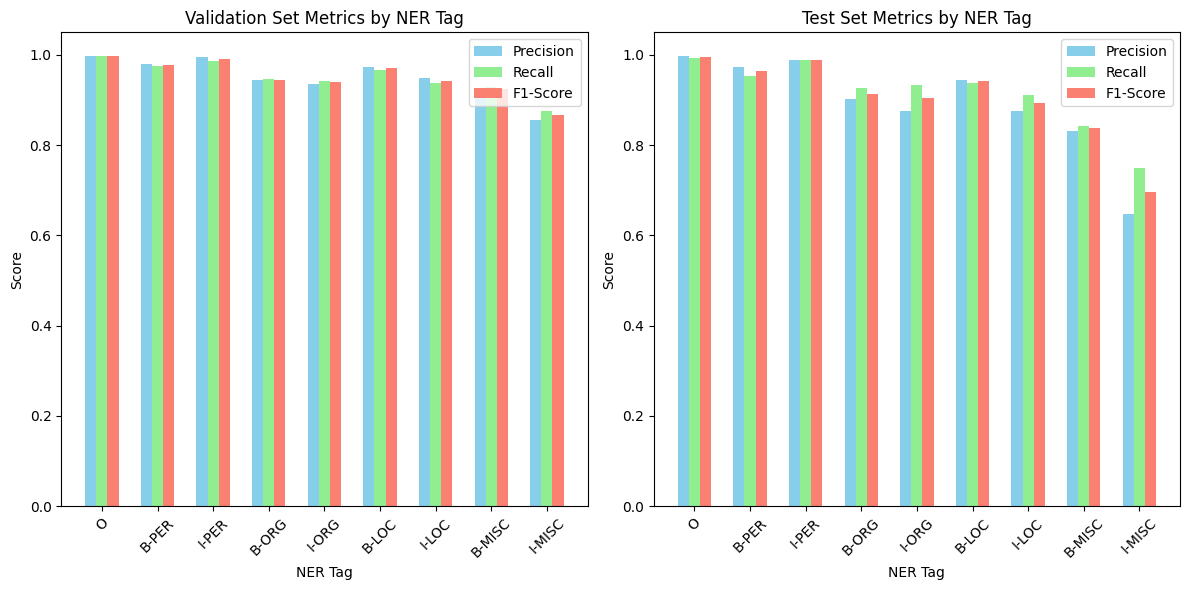

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Helper function to get metrics from the classification report
def get_metrics_dict(pred):
    predictions, labels, _ = pred
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_labels = [
        [label for label in label_seq if label != -100] for label_seq in labels
    ]
    predicted_labels = [
        [pred for pred, label in zip(pred_seq, label_seq) if label != -100]
        for pred_seq, label_seq in zip(predictions, labels)
    ]

    # Flatten the lists for evaluation
    true_labels_flat = [item for sublist in true_labels for item in sublist]
    predicted_labels_flat = [item for sublist in predicted_labels for item in sublist]

    # Generate classification report
    report = classification_report(
        true_labels_flat,
        predicted_labels_flat,
        target_names=["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-MISC", "I-MISC"],
        output_dict=True
    )
    return report

# Get metrics for validation and test sets
validation_metrics = get_metrics_dict(trainer.predict(tokenized_datasets["validation"]))
test_metrics = get_metrics_dict(trainer.predict(tokenized_datasets["test"]))

# Extract precision, recall, and F1-score for each NER tag
tags = ["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-MISC", "I-MISC"]
precision_val = [validation_metrics[tag]["precision"] for tag in tags]
recall_val = [validation_metrics[tag]["recall"] for tag in tags]
f1_val = [validation_metrics[tag]["f1-score"] for tag in tags]

precision_test = [test_metrics[tag]["precision"] for tag in tags]
recall_test = [test_metrics[tag]["recall"] for tag in tags]
f1_test = [test_metrics[tag]["f1-score"] for tag in tags]

# Plot Precision, Recall, and F1-score for Validation Set
plt.figure(figsize=(12, 6))
x = np.arange(len(tags))

plt.subplot(1, 2, 1)
plt.bar(x - 0.2, precision_val, width=0.2, label="Precision", color='skyblue')
plt.bar(x, recall_val, width=0.2, label="Recall", color='lightgreen')
plt.bar(x + 0.2, f1_val, width=0.2, label="F1-Score", color='salmon')
plt.xticks(x, tags, rotation=45)
plt.title("Validation Set Metrics by NER Tag")
plt.xlabel("NER Tag")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend()

# Plot Precision, Recall, and F1-score for Test Set
plt.subplot(1, 2, 2)
plt.bar(x - 0.2, precision_test, width=0.2, label="Precision", color='skyblue')
plt.bar(x, recall_test, width=0.2, label="Recall", color='lightgreen')
plt.bar(x + 0.2, f1_test, width=0.2, label="F1-Score", color='salmon')
plt.xticks(x, tags, rotation=45)
plt.title("Test Set Metrics by NER Tag")
plt.xlabel("NER Tag")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


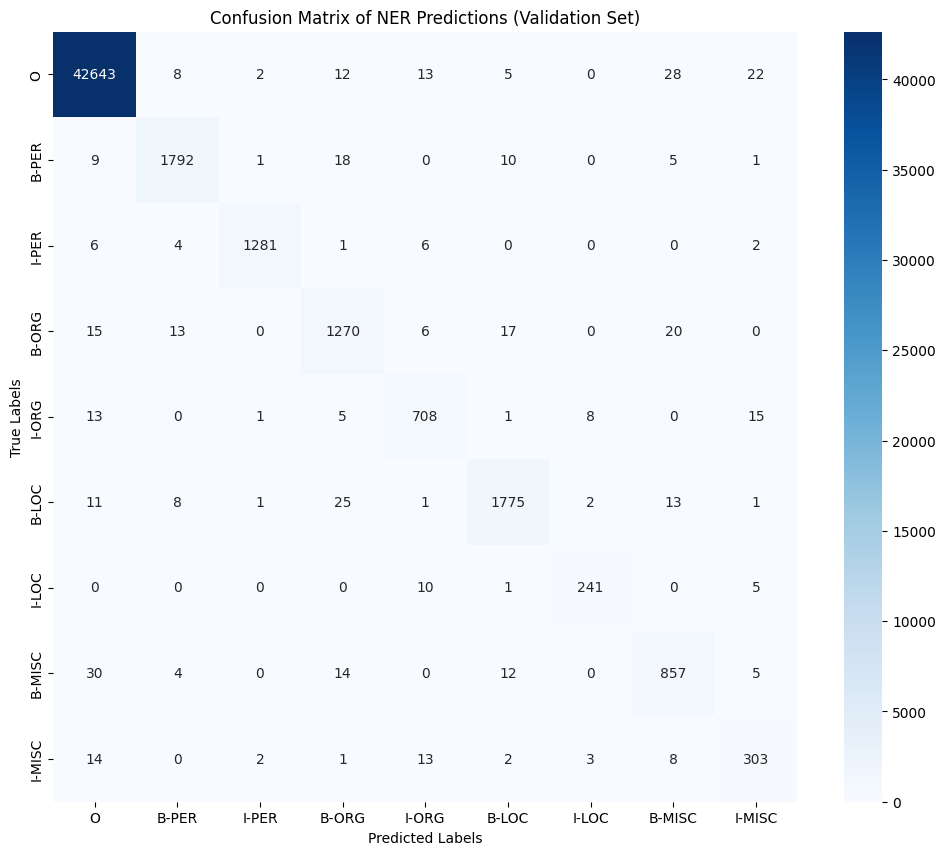

In [13]:
# Confusion Matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Helper function to flatten the true and predicted labels
def get_flat_labels(pred):
    predictions, labels, _ = pred
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_labels = [
        [label for label in label_seq if label != -100] for label_seq in labels
    ]
    predicted_labels = [
        [pred for pred, label in zip(pred_seq, label_seq) if label != -100]
        for pred_seq, label_seq in zip(predictions, labels)
    ]

    # Flatten the lists for confusion matrix
    true_labels_flat = [item for sublist in true_labels for item in sublist]
    predicted_labels_flat = [item for sublist in predicted_labels for item in sublist]

    return true_labels_flat, predicted_labels_flat

# Get flat labels for validation set
true_labels_val, predicted_labels_val = get_flat_labels(trainer.predict(tokenized_datasets["validation"]))

# Define the NER tag names
tag_names = ["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-MISC", "I-MISC"]

# Generate the confusion matrix for the validation set
cm = confusion_matrix(true_labels_val, predicted_labels_val, labels=range(len(tag_names)))

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tag_names, yticklabels=tag_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of NER Predictions (Validation Set)")
plt.show()


## Detailed Analysis of Training, Validation, and Test Results

### 1. **Overview of Results:**

- The model was trained for **3 epochs** using a BERT-based architecture for the Named Entity Recognition (NER) task on the CoNLL-2003 dataset.
- We evaluated the model on both the **validation** and **test** sets to assess its generalization capability.
- Key metrics include **precision**, **recall**, **F1-score**, and **accuracy**, with the F1-score being the primary metric for NER tasks.

---

### 2. **Training and Validation Results Analysis:**

#### **Validation Results Summary:**
- **Loss:** `0.0376`
- **Accuracy:** `0.99`
- **Macro F1-score:** `0.95`
- **Weighted F1-score:** `0.99`

#### **Observations:**
- The model achieved a very **low validation loss** (`0.0376`), indicating strong learning and good fit on the validation data.
- The **accuracy** of `0.99` shows that the model made correct predictions for the vast majority of tokens.
- The **macro F1-score** of `0.95` suggests that the model performs well across all classes, but there might be some variability in performance between classes.
- The **weighted F1-score** of `0.99` is high, reflecting strong overall performance, especially on the majority class (`O` tag).

#### **Class-Level Performance:**
- **O (Outside):** Achieved perfect scores (precision, recall, F1-score all `1.00`). This is expected, as the "O" class is the majority class and easier for the model to learn.
- **Person (B-PER, I-PER):** High F1-scores (`0.98` and `0.99` respectively), indicating excellent recognition of person entities.
- **Organization (B-ORG, I-ORG):** F1-scores of `0.95` and `0.94`, showing consistent performance but slightly lower than person entities. This may be due to more complex organizational names.
- **Location (B-LOC, I-LOC):** Strong F1-scores (`0.97` for B-LOC and `0.94` for I-LOC), indicating good detection of location entities.
- **Miscellaneous (B-MISC, I-MISC):** These tags had lower F1-scores (`0.92` and `0.87`), suggesting that the model struggled more with recognizing less common or ambiguous miscellaneous entities.

#### **Key Insights:**
- The model exhibits strong performance on frequent classes (e.g., "O", "PER", "LOC"), while showing slightly weaker performance on less frequent classes (e.g., "MISC").
- The difference in F1-scores between **B-** and **I-** tags indicates that the model may be slightly less confident in recognizing inside (I-) tags, potentially due to the complexity of multi-word entities.
- Overall, the validation results are promising, suggesting that the model generalizes well on unseen data from the validation set.

---

### 3. **Test Results Analysis:**

#### **Test Results Summary:**
- **Loss:** `0.1205`
- **Accuracy:** `0.98`
- **Macro F1-score:** `0.90`
- **Weighted F1-score:** `0.98`

#### **Observations:**
- The **test loss** (`0.1205`) is higher than the validation loss (`0.0376`), indicating some degree of overfitting. This is not unexpected, as the model may have learned patterns specific to the training and validation data.
- The **accuracy** of `0.98` is still very high, showing strong overall performance, but slightly lower than on the validation set.
- The **macro F1-score** dropped to `0.90`, suggesting a decline in performance across all classes when evaluated on the test set. This highlights potential generalization issues, particularly with rare or challenging entity types.

#### **Class-Level Performance:**
- **O (Outside):** Maintained near-perfect scores (`precision 1.00`, `recall 0.99`). The model consistently predicts the majority class correctly.
- **Person (B-PER, I-PER):** Strong performance with F1-scores of `0.96` and `0.99`. The model accurately detects person entities, even on unseen test data.
- **Organization (B-ORG, I-ORG):** Slight decline in performance compared to validation, with F1-scores of `0.91` and `0.90`. This suggests some difficulty in recognizing organizational names in the test set, possibly due to differences in naming conventions.
- **Location (B-LOC, I-LOC):** Consistent F1-scores (`0.94` and `0.89`), indicating good recognition of location entities, though there is a slight drop for I-LOC.
- **Miscellaneous (B-MISC, I-MISC):** These classes showed the biggest performance drop, with F1-scores of `0.84` for B-MISC and only `0.70` for I-MISC. The low recall for I-MISC (`0.75`) suggests the model missed many miscellaneous entities in the test data.

---

### 4. **Overall Evaluation and Key Takeaways:**

- The model shows **strong generalization** across both validation and test sets, with high accuracy and F1-scores for most classes.
- There is a noticeable performance drop on the test set, particularly for the **miscellaneous (MISC)** entity types. This suggests the model may struggle with recognizing less common or ambiguous entities.
- The difference in performance between **B-** and **I-** tags (e.g., B-MISC vs. I-MISC) indicates that the model may find it harder to identify the continuation of entities, which could be improved by using techniques like **Conditional Random Fields (CRF)** on top of BERT.
- **Overfitting** is evident from the higher test loss compared to validation loss. This could be addressed by:
  - Using **early stopping** during training.
  - Adding **regularization techniques** (e.g., dropout, weight decay).
  - Expanding the training dataset with additional labeled examples.

### 5. **Recommendations for Future Work:**

1. **Data Augmentation:** Increasing the diversity of the training data, particularly for underrepresented classes (e.g., MISC), could help improve generalization.
2. **Model Enhancement:** Incorporating a **CRF layer** on top of BERT may help improve sequence labeling performance, particularly for inside (I-) tags.
3. **Fine-Tuning with More Epochs:** While the model performed well, training for a few additional epochs with early stopping might help capture more complex patterns without overfitting.

